In [0]:
# Загружаем данные с помощие команды !wget 
# Для того, чтобы игнорировать сообщения в процессе загрузки используем магическую команду %%capture в первой строке.
%%capture
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1LUPU6s-o5SfA37K9d5CfE5DdbchRyT88' -O 'test.csv'
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1ldbk9InLQFjRQvvqJkUe2kP1-alxMkwB' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1ldbk9InLQFjRQvvqJkUe2kP1-alxMkwB" -O 'train.csv' && rm -rf /tmp/cookies.txt

In [0]:
import os
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
import pandas as pd
from tqdm import tqdm_notebook
import cv2
from IPython.display import clear_output


%tensorflow_version 1.x
from keras.preprocessing.image import ImageDataGenerator 
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPooling2D 
from keras.layers import Activation, Dropout, Flatten, Dense, Flatten
import tensorflow as tf
import keras
from sklearn.metrics import accuracy_score, f1_score
from keras import backend as K

from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

EMOTIONS = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral'] 
N_CLASSES = len(EMOTIONS)

In [0]:
# каждое изображение растянуто в строку в таблице
# преобразуем в привычный массив, не создавая папки с изображениями явным образом,
# т.к. метод .fit() работает гораздо быстрее чем .fit_generator()
# для контроля переобучения выделите из X_train, y_train данные для валидации

img_width, img_height = (48,48)

def str_to_image(image_blob):
    image_string = image_blob[0].split(' ')
    image_data = np.asarray(image_string, dtype=np.uint8).reshape(48,48)
    return image_data
 
def csv_to_array(csv):
    X = csv.pixels.values
    X = np.apply_along_axis(str_to_image, 1, X[:,None])/255.
    X = X[...,None]
    return X

train = pd.read_csv('train.csv') # для обучения и валидации
test = pd.read_csv('test.csv') # для сабмита на кагл

y_train = train.emotion.values
X_train = csv_to_array(train)
X_test= csv_to_array(test)

y_train = keras.utils.to_categorical(y_train, N_CLASSES)
# X_val, y_val = ... # Ваш код здесь

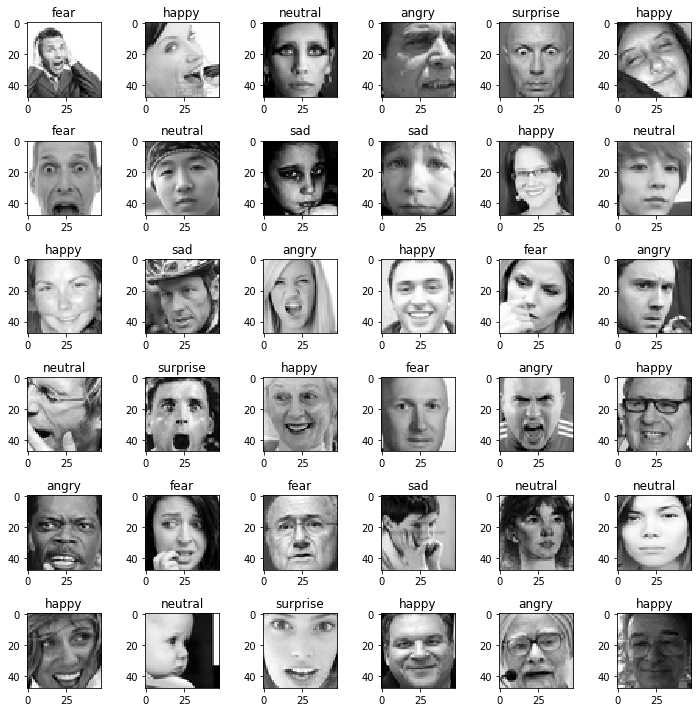

In [0]:
# посмотрим как выглядят изображения
N_IMAGES_TO_PLOT = 36
fig, axes = plt.subplots(nrows=np.sqrt(N_IMAGES_TO_PLOT).astype(int), 
                         ncols = np.sqrt(N_IMAGES_TO_PLOT).astype(int),
                         figsize=(10,10))

rand_indx = np.random.choice(np.arange(N_IMAGES_TO_PLOT), size=N_IMAGES_TO_PLOT, replace=False)
for ax, emotion_index, img in zip(axes.flatten(), train.emotion.values[rand_indx], X_train[rand_indx]):
    img = img[:,:,0] # [48,48,1] -> [48,48]
    ax.imshow(img, cmap='gray')
    emotion = EMOTIONS[emotion_index]
    ax.set_title(emotion)
plt.tight_layout()
plt.show()

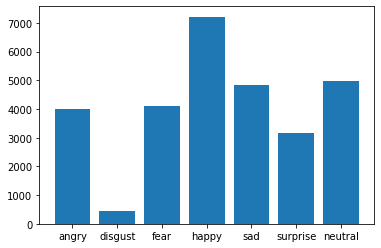

In [0]:
# посмотрим насколько сбалансированны классы в обучающей выборке
train_count = train.groupby('emotion').count()
plt.bar(x = EMOTIONS,
        height=train_count.values.flatten())
plt.show()

Виден сильный дисбаланс между классом `disguist` и остальными

In [0]:

if K.image_data_format() == 'channels_first': 
    input_shape = (1, img_width, img_height) 
else: 
    input_shape = (img_width, img_height, 1) 

model = Sequential() 

model.add(Flatten())
model.add(Dense(1024)) 
model.add(Activation('relu')) 
model.add(Dropout(0.2)) 
model.add(Dense(1024)) 
model.add(Dropout(0.2)) 
model.add(Dense(N_CLASSES)) 
model.add(Activation('softmax'))  

In [0]:
model.compile(loss='categorical_crossentropy', 
              optimizer='nadam', 
              metrics=['accuracy']) 

N_EPOCHS = 100
history_cnn = model.fit(X_train, 
                        y_train,
                        batch_size=100,
                        epochs=N_EPOCHS,
                        workers = 400)

    

Epoch 1/100
28709/28709 [==============================] - 3s 92us/step - loss: 13.3543 - acc: 0.1688
Epoch 2/100
28709/28709 [==============================] - 2s 82us/step - loss: 13.3486 - acc: 0.1717
Epoch 3/100
28709/28709 [==============================] - 2s 84us/step - loss: 13.3256 - acc: 0.1732
Epoch 4/100
28709/28709 [==============================] - 2s 78us/step - loss: 13.3255 - acc: 0.1732
Epoch 5/100
28709/28709 [==============================] - 2s 79us/step - loss: 13.3256 - acc: 0.1732
Epoch 6/100
28709/28709 [==============================] - 2s 80us/step - loss: 13.3255 - acc: 0.1732
Epoch 7/100
28709/28709 [==============================] - 2s 85us/step - loss: 13.3255 - acc: 0.1732
Epoch 8/100
28709/28709 [==============================] - 2s 85us/step - loss: 13.3255 - acc: 0.1732
Epoch 9/100
28709/28709 [==============================] - 2s 86us/step - loss: 13.3255 - acc: 0.1732
Epoch 10/100
28709/28709 [==============================] - 2s 81us/step - loss: 1

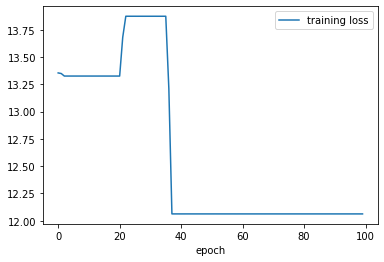

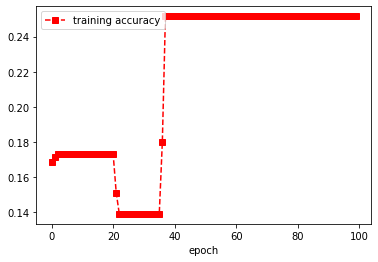

In [0]:
plt.figure()
plt.plot(history_cnn.history['loss'], label='training loss')
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(history_cnn.history['acc'], '--s', color='r', label='training accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

### Как сделать лучше?

 - Начните со сверточной нейронной сети: Conv2D -> Activation -> ReLU -> Conv2D ... -> Dense
 - Transfer Learning: взять предобученную на большом датасете модель и слегка дообучить ее, подстроив под новую задачу. Это возможно, т.к. большая часть слоев нейронной сети, обученной для классификации изображений, извлекает признаки из изображения, а последний, линейный слой, выступает в роли классификатора. Подробнее о том как это использовать - [здесь](https://neurohive.io/ru/tutorial/transfer-learning-keras/)
 - Аугментация данных: небольшой размер датасета и большое количество параметров модели (что характерно для нейронных сетей) способствует переобучению. Проблему недостатка данных можно решить трансформацией батча на этапе обучения, например, вращая изображения или меняя уровень яркости. Подробнее - [здесь](https://machinelearningmastery.com/image-augmentation-deep-learning-keras/)  
 - Попробуйте убрать дисбаланс в данных, использовав простой oversampling: например для каждого класса добавьте в него случайно выбранные из него-же данные.

In [0]:
# вычисляет и скачивает файл для submission на kaggle
def submit(model, X_test):

    prediction=model.predict(X_test,  workers=400)

    pred_classes = prediction.argmax(-1)
    df = pd.DataFrame(data = {'Id':np.arange(len(pred_classes)),
                              'Category':pred_classes})

    df.to_csv('submission.csv', index=False)
    files.download('submission.csv') 

submit(model, X_test)